In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
import sys
sys.path.append("/content/drive/MyDrive/pytorch_tabnet")

In [4]:
from tab_model import TabNetClassifier

In [5]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import roc_auc_score, precision_recall_curve, f1_score

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

=====================Data preparation=============================

In [7]:
# -----------------
# Helper: stratified sampling
# -----------------
def stratified_sample(df, target_col, frac=None, n=None, random_state=42):
    """Return stratified sample keeping target ratio"""
    if frac is not None:
        df_sampled = df.groupby(target_col, group_keys=False)\
                       .apply(lambda x: x.sample(frac=frac, random_state=random_state))
    elif n is not None:
        class_counts = df[target_col].value_counts()
        total = class_counts.sum()
        df_sampled = []
        for c, count in class_counts.items():
            take = int(n * (count / total))
            df_sampled.append(df[df[target_col] == c].sample(n=take, random_state=random_state))
        df_sampled = pd.concat(df_sampled)
    else:
        df_sampled = df
    return df_sampled.sample(frac=1.0, random_state=random_state).reset_index(drop=True)

In [8]:
dataset = "B"

if dataset == "A":
  dataset_name = "/content/drive/MyDrive/wustl_iiot_2021.csv"
  target = 'Target'
  drop_cols = ["StartTime", "LastTime", "Traffic", "SrcAddr", "DstAddr"]
  frac=0.1
elif dataset == "B":
  dataset_name = "/content/drive/MyDrive/creditcard.csv"
  target = 'Class'
  drop_cols = ["Time"]
  frac=0.5

In [9]:
df = pd.read_csv(dataset_name)

df = df.drop(columns=[c for c in drop_cols if c in df.columns])


print(f"Original dataset shape: {df.shape}, anomaly ratio={df[target].mean():.4%}")

# Stratified sampling
df_sampled = stratified_sample(df, target, frac=frac, random_state=0)
print(f"Sampled dataset shape: {df_sampled.shape}, anomaly ratio={df_sampled[target].mean():.4%}")

df_sampled = df_sampled.reset_index(drop=True)

features = df_sampled.columns

train_df, test_df = train_test_split(
    df_sampled, test_size=0.2, stratify=df_sampled[target], random_state=0
)

train_df, valid_df = train_test_split(
    train_df, test_size= 0.2 / 0.6, stratify=train_df[target], random_state=0
)

print(f"Train shape: {train_df.shape}, anomaly ratio={train_df[target].mean():.4%}")
print(f"Valid shape: {valid_df.shape}, anomaly ratio={valid_df[target].mean():.4%}")
print(f"Test shape:  {test_df.shape},  anomaly ratio={test_df[target].mean():.4%}")

# Add the "Set" column
train_df["Set"] = "train"
valid_df["Set"] = "valid"
test_df["Set"] = "test"

# Combine them back together
train = pd.concat([train_df, valid_df, test_df]).reset_index(drop=True)

train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index


categorical_columns = []
categorical_dims = {}

nunique = train.nunique()
types = train.dtypes

for col in train.columns:
    if types[col] == 'object':
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

unused_feat = ["Set"]

features = [col for col in df_sampled.columns if col not in unused_feat + [target]]

print(features)

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

print(categorical_columns)
print(cat_dims)

Original dataset shape: (284807, 30), anomaly ratio=0.1727%


/tmp/ipython-input-2184620091.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=frac, random_state=random_state))


Sampled dataset shape: (142404, 30), anomaly ratio=0.1727%
Train shape: (75948, 30), anomaly ratio=0.1725%
Valid shape: (37975, 30), anomaly ratio=0.1738%
Test shape:  (28481, 30),  anomaly ratio=0.1720%
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
['Set']
[]


In [10]:
target_enc = LabelEncoder()
train[target] = target_enc.fit_transform(train[target].values)

In [11]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [12]:
# Split the data into categorical and continuous parts
X_train_categ = torch.tensor(X_train[:, cat_idxs], dtype=torch.long)
X_train_cont = torch.tensor(np.delete(X_train, cat_idxs, axis=1), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_valid_categ = torch.tensor(X_valid[:, cat_idxs], dtype=torch.long)
X_valid_cont = torch.tensor(np.delete(X_valid, cat_idxs, axis=1), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

X_test_categ = torch.tensor(X_test[:, cat_idxs], dtype=torch.long)
X_test_cont = torch.tensor(np.delete(X_test, cat_idxs, axis=1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_categ, X_train_cont, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(X_valid_categ, X_valid_cont, y_valid_tensor)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test_categ, X_test_cont, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

======================================================================

==================================Model================================

=======================================================================

In [13]:
!nvidia-smi

Thu Oct 16 13:49:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
opt_ndna = 32
opt_nsteps = 4
opt_gamma = 1.0
opt_lambda = 1.0
opt_lr = 0.025
opt_reg_m = 10

In [15]:
clf = TabNetClassifier(
        n_d=opt_ndna,
        n_a=opt_ndna,
        n_steps=4,
        gamma=opt_gamma,
        lambda_sparse=opt_lambda,
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        optimizer_params=dict(lr=opt_lr),
        mask_type = 'softmax',
        reg_m=opt_reg_m
    )
    # max epoch 50

Device used cuda: 0


In [16]:
clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'], batch_size=4096,
        virtual_batch_size=128,
        max_epochs=50, eval_metric=['auc']
    )

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


epoch 0  | loss: 58.89356| train_auc: 0.79334 | valid_auc: 0.73328 |  0:00:52s
epoch 1  | loss: 58.71385| train_auc: 0.84091 | valid_auc: 0.78856 |  0:01:43s
epoch 2  | loss: 58.8293 | train_auc: 0.91091 | valid_auc: 0.8215  |  0:02:35s
epoch 3  | loss: 58.79368| train_auc: 0.9394  | valid_auc: 0.82626 |  0:03:29s
epoch 4  | loss: 58.88398| train_auc: 0.92396 | valid_auc: 0.8834  |  0:04:21s
epoch 5  | loss: 58.76532| train_auc: 0.96467 | valid_auc: 0.88524 |  0:05:12s
epoch 6  | loss: 58.75136| train_auc: 0.96232 | valid_auc: 0.91417 |  0:06:03s
epoch 7  | loss: 58.734  | train_auc: 0.97133 | valid_auc: 0.91074 |  0:06:54s
epoch 8  | loss: 58.87055| train_auc: 0.9821  | valid_auc: 0.95233 |  0:07:46s
epoch 9  | loss: 58.77785| train_auc: 0.98983 | valid_auc: 0.9587  |  0:08:36s
epoch 10 | loss: 58.74924| train_auc: 0.98555 | valid_auc: 0.94834 |  0:09:26s
epoch 11 | loss: 58.81731| train_auc: 0.98008 | valid_auc: 0.89939 |  0:10:16s
epoch 12 | loss: 58.73082| train_auc: 0.94263 | vali

In [17]:
y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)


print(f"FINAL TEST SCORE: {test_acc}")
print(classification_report(y_test, y_pred))

FINAL TEST SCORE: 0.9988062216916541
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.64      0.69      0.67        49

    accuracy                           1.00     28481
   macro avg       0.82      0.85      0.83     28481
weighted avg       1.00      1.00      1.00     28481



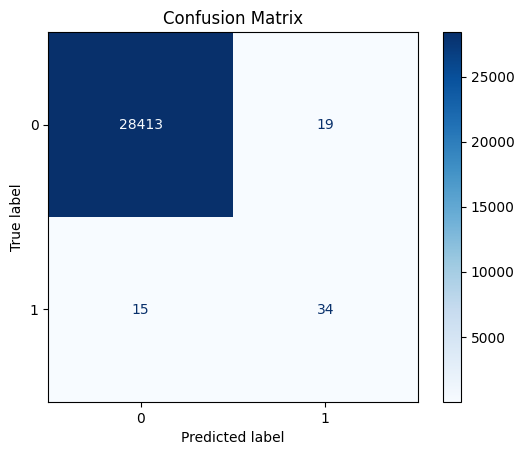

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [19]:
# Accuracy, Precision, Recall, F1-Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print individual scores
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {auc:.4f}")

# Classification report for a detailed overview
print(classification_report(y_test, y_pred))

Accuracy: 0.9988
Precision: 0.6415
Recall: 0.6939
F1-Score: 0.6667
ROC-AUC: 0.8466
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.64      0.69      0.67        49

    accuracy                           1.00     28481
   macro avg       0.82      0.85      0.83     28481
weighted avg       1.00      1.00      1.00     28481



==========================================================================================

In [20]:
clf1 = TabNetClassifier(
        n_d=opt_ndna,
        n_a=opt_ndna,
        n_steps=4,
        gamma=opt_gamma,
        lambda_sparse=opt_lambda,
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        optimizer_params=dict(lr=opt_lr),
        mask_type = 'softmax',
        reg_m=opt_reg_m
    )
    # max epoch 50

Device used cuda: 0


In [21]:
clf1.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'], batch_size=4096,
        virtual_batch_size=128,
        max_epochs=50, eval_metric=['accuracy']
    )

epoch 0  | loss: 58.89356| train_accuracy: 0.99908 | valid_accuracy: 0.99876 |  0:01:04s
epoch 1  | loss: 58.71385| train_accuracy: 0.99876 | valid_accuracy: 0.99863 |  0:02:05s
epoch 2  | loss: 58.8293 | train_accuracy: 0.99896 | valid_accuracy: 0.99866 |  0:02:57s
epoch 3  | loss: 58.79368| train_accuracy: 0.99907 | valid_accuracy: 0.99897 |  0:03:52s
epoch 4  | loss: 58.88398| train_accuracy: 0.99892 | valid_accuracy: 0.99889 |  0:04:43s
epoch 5  | loss: 58.76532| train_accuracy: 0.99912 | valid_accuracy: 0.99874 |  0:05:33s
epoch 6  | loss: 58.75136| train_accuracy: 0.99914 | valid_accuracy: 0.99905 |  0:06:25s
epoch 7  | loss: 58.734  | train_accuracy: 0.99925 | valid_accuracy: 0.99884 |  0:07:15s
epoch 8  | loss: 58.87055| train_accuracy: 0.9993  | valid_accuracy: 0.99897 |  0:08:06s
epoch 9  | loss: 58.77785| train_accuracy: 0.99887 | valid_accuracy: 0.99868 |  0:08:57s
epoch 10 | loss: 58.74924| train_accuracy: 0.99928 | valid_accuracy: 0.99897 |  0:09:47s
epoch 11 | loss: 58.8

In [22]:
y_pred1 = clf1.predict(X_test)
test_acc1 = accuracy_score(y_pred=y_pred1, y_true=y_test)


print(f"FINAL TEST SCORE: {test_acc1}")
print(classification_report(y_test, y_pred1))


# Accuracy, Precision, Recall, F1-Score
accuracy1 = accuracy_score(y_test, y_pred1)
precision1 = precision_score(y_test, y_pred1)
recall1 = recall_score(y_test, y_pred1)
f11 = f1_score(y_test, y_pred1)
auc1 = roc_auc_score(y_test, y_pred1)

# Print individual scores
print(f"Accuracy: {accuracy1:.4f}")
print(f"Precision: {precision1:.4f}")
print(f"Recall: {recall1:.4f}")
print(f"F1-Score: {f11:.4f}")
print(f"ROC-AUC: {auc1:.4f}")

FINAL TEST SCORE: 0.9991924440855307
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.86      0.63      0.73        49

    accuracy                           1.00     28481
   macro avg       0.93      0.82      0.86     28481
weighted avg       1.00      1.00      1.00     28481

Accuracy: 0.9992
Precision: 0.8611
Recall: 0.6327
F1-Score: 0.7294
ROC-AUC: 0.8162
